<a href="https://colab.research.google.com/github/fastdatascience/clinical_trial_risk/blob/fixes_nov_2022/train/ctgov/TrainNumSubjects_08_num_subjects_rulebased_original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json

# df_annotations = pd.read_csv("all_annotations.csv")


# Get data

In [3]:
# with open("protocols.pkl.gz", "rb") as f:
#     file_to_pages = pkl.load(f)

In [4]:
# import spacy
# nlp = spacy.blank("en")

In [5]:
# texts = []

# for i in range(len(df_annotations)):
#     file_name = df_annotations.file.iloc[i]
    
#     pages= file_to_pages[file_name]
    
#     text = ""
#     for page in pages:
#         doc = nlp(page)
        
#         is_include = [False] * len(doc)
#         for tok in doc:
#             if tok.text.lower() in {"phase"}:
#                 for token_index in range(tok.i - 20, tok.i + 20):
#                     if token_index >= 0 and token_index < len(doc):
#                         is_include[token_index] = True
        
#         for token_index in range(len(doc)):
#             if is_include[token_index]:
#                 text += doc[token_index].text + doc[token_index].whitespace_
                
                
#     if text == "":
#         print ("nothing found", file_name, df_annotations.phase.iloc[i])
#         text = " ".join(pages)
#         if len(text) > 100000:
#             text = text[:100000]
#     else:
#         print ("found", file_name, df_annotations.phase.iloc[i])

#     texts.append(text)
# df_annotations["text"] = texts

In [6]:
# df_annotations.to_csv("filtered_for_phase.csv.bz2")

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
df_annotations= pd.read_csv("/content/drive/MyDrive/data/filtered_for_phase_arms_subjects_02.csv.bz2")

In [9]:
#df_annotations.text = df_annotations.text.apply(lambda t : t[:10000] if len(t) > 10000 else t)

In [10]:
def get_num_subjects_clean(num):
    if pd.isna(num):
        return None
    if num >= 10000:
        return "10000+"
    if num >= 1000:
        return "1000+"
    if num >= 500:
        return "500+"
    if num >= 200:
        return "200+"
    if num >= 100:
        return "100+"
    if num >= 50:
        return "50+"
    if num >= 25:
        return "25+"
    return "1-24"
df_annotations["num_subjects_clean"] = df_annotations["num_subjects"].apply(get_num_subjects_clean)

In [11]:
df_annotations["num_subjects_clean"].value_counts()

1-24      2980
25+       2119
50+       2016
100+      1674
200+      1656
500+       816
1000+      547
10000+     112
Name: num_subjects_clean, dtype: int64

In [12]:
# df_annotations = pd.read_csv("filtered_for_phase.csv.bz2")

In [13]:
# del file_to_pages

In [14]:
phase_map = {"Phase 2":"2",
"Phase 3":"3",
"Phase 4":"4",
"Phase 1":"1",
"Phase 1/Phase 2":"1.5",
"Not Applicable":"0",
"Phase 2/Phase 3":"2.5",
"Early Phase 1":"0.5"}
df_annotations["phase_clean"] = df_annotations["phase"].apply(lambda x : phase_map.get(x, None))

In [15]:
phase_clean_map = {}
for idx, val in enumerate(sorted(set(phase_map.values()), key = lambda x : float(x))):
  phase_clean_map[val] = idx
# invert the dictionary
phase_lookup = {v: k for k, v in phase_clean_map.items()}

phase_list = [phase_lookup[x] for x in sorted(phase_lookup)]
phase_list

['0', '0.5', '1', '1.5', '2', '2.5', '3', '4']

In [16]:
def get_num_arms_clean(num):
    if pd.isna(num):
        return None
    if num >= 5:
        num = 5
    return num
df_annotations["num_arms_clean"] = df_annotations["num_arms"].apply(get_num_arms_clean)

# Begin existing rule based

In [62]:
import bz2
import pickle as pkl
import pandas as pd
from collections import Counter
import numpy as np
import spacy
from spacy.matcher import Matcher
import re
from os.path import exists


demonym_to_country_code = {'ARUBAN': 'AW',
                           'AFGHAN': 'AF',
                           'ANGOLAN': 'AO',
                           'ANGUILLIAN': 'AI',
                           'ALBANIAN': 'AL',
                           'EMIRATI': 'AE',
                           'ARGENTINEAN': 'AR',
                           'ARMENIAN': 'AM',
                           'AMERICAN SAMOAN': 'AS',
                           'FRENCH': 'PM',
                           'ANTIGUAN': 'AG',
                           'BARBUDAN': 'AG',
                           'AUSTRALIAN': 'AU',
                           'AUSTRIAN': 'AT',
                           'AZERBAIJANI': 'AZ',
                           'BURUNDIAN': 'BI',
                           'BELGIAN': 'BE',
                           'BENINESE': 'BJ',
                           'BURKINABE': 'BF',
                           'BANGLADESHI': 'BD',
                           'BULGARIAN': 'BG',
                           'BAHRAINI': 'BH',
                           'BAHAMIAN': 'BS',
                           'BOSNIAN': 'BA',
                           'HERZEGOVINIAN': 'BA',
                           'BELARUSIAN': 'BY',
                           'BELIZEAN': 'BZ',
                           'BERMUDIAN': 'BM',
                           'BOLIVIAN': 'BO',
                           'BRAZILIAN': 'BR',
                           'BARBADIAN': 'BB',
                           'BRUNEIAN': 'BN',
                           'BHUTANESE': 'BT',
                           'MOTSWANA': 'BW',
                           'CENTRAL AFRICAN': 'CF',
                           'CANADIAN': 'CA',
                           'COCOS ISLANDER': 'CC',
                           'SWISS': 'CH',
                           'CHILEAN': 'CL',
                           'CHINESE': 'MO',
                           'IVORIAN': 'CI',
                           'CAMEROONIAN': 'CM',
                           'CONGOLESE': 'CG',
                           'COOK ISLANDER': 'CK',
                           'COLOMBIAN': 'CO',
                           'COMORAN': 'KM',
                           'CAPE VERDIAN': 'CV',
                           'COSTA RICAN': 'CR',
                           'CUBAN': 'CU',
                           'CHRISTMAS ISLAND': 'CX',
                           'CAYMANIAN': 'KY',
                           'CYPRIOT': 'CY',
                           'CZECH': 'CZ',
                           'GERMAN': 'DE',
                           'DJIBOUTI': 'DJ',
                           'DOMINICAN': 'DO',
                           'DANISH': 'DK',
                           'ALGERIAN': 'DZ',
                           'ECUADOREAN': 'EC',
                           'EGYPTIAN': 'EG',
                           'ERITREAN': 'ER',
                           'SAHRAWI': 'EH',
                           'SPANISH': 'ES',
                           'ESTONIAN': 'EE',
                           'ETHIOPIAN': 'ET',
                           'FINNISH': 'FI',
                           'FIJIAN': 'FJ',
                           'FALKLAND ISLANDER': 'FK',
                           'FAROESE': 'FO',
                           'MICRONESIAN': 'FM',
                           'GABONESE': 'GA',
                           'BRITISH': 'GB',
                           'GEORGIAN': 'GE',
                           'CHANNEL ISLANDER': 'JE',
                           'GHANAIAN': 'GH',
                           'GIBRALTAR': 'GI',
                           'GUINEAN': 'GN',
                           'GUADELOUPIAN': 'GP',
                           'GAMBIAN': 'GM',
                           'GUINEA-BISSAUAN': 'GW',
                           'EQUATORIAL GUINEAN': 'GQ',
                           'GREEK': 'GR',
                           'GRENADIAN': 'GD',
                           'GREENLANDIC': 'GL',
                           'GUATEMALAN': 'GT',
                           'GUAMANIAN': 'GU',
                           'GUYANESE': 'GY',
                           'HEARD AND MCDONALD ISLANDER': 'HM',
                           'HONDURAN': 'HN',
                           'CROATIAN': 'HR',
                           'HAITIAN': 'HT',
                           'HUNGARIAN': 'HU',
                           'INDONESIAN': 'ID',
                           'MANX': 'IM',
                           'INDIAN': 'IO',
                           'IRISH': 'IE',
                           'IRANIAN': 'IR',
                           'IRAQI': 'IQ',
                           'ICELANDER': 'IS',
                           'ISRAELI': 'IL',
                           'ITALIAN': 'IT',
                           'JAMAICAN': 'JM',
                           'JORDANIAN': 'JO',
                           'JAPANESE': 'JP',
                           'KAZAKHSTANI': 'KZ',
                           'KENYAN': 'KE',
                           'KIRGHIZ': 'KG',
                           'CAMBODIAN': 'KH',
                           'I-KIRIBATI': 'KI',
                           'KIRIBATI': 'KI',
                           'KITTIAN AND NEVISIAN': 'KN',
                           'SOUTH KOREAN': 'KR',
                           'KUWAITI': 'KW',
                           'LAOTIAN': 'LA',
                           'LEBANESE': 'LB',
                           'LIBERIAN': 'LR',
                           'LIBYAN': 'LY',
                           'SAINT LUCIAN': 'LC',
                           'LIECHTENSTEINER': 'LI',
                           'SRI LANKAN': 'LK',
                           'MOSOTHO': 'LS',
                           'LITHUANIAN': 'LT',
                           'LUXEMBOURGER': 'LU',
                           'LATVIAN': 'LV',
                           'MOROCCAN': 'MA',
                           'MONEGASQUE': 'MC',
                           'MOLDOVAN': 'MD',
                           'MALAGASY': 'MG',
                           'MALDIVAN': 'MV',
                           'MEXICAN': 'MX',
                           'MARSHALLESE': 'MH',
                           'MACEDONIAN': 'MK',
                           'MALIAN': 'ML',
                           'MALTESE': 'MT',
                           'MONGOLIAN': 'MN',
                           'AMERICAN': 'US',
                           'MOZAMBICAN': 'MZ',
                           'MAURITANIAN': 'MR',
                           'MONTSERRATIAN': 'MS',
                           'MAURITIAN': 'MU',
                           'MALAWIAN': 'MW',
                           'MALAYSIAN': 'MY',
                           'NAMIBIAN': 'NA',
                           'NEW CALEDONIAN': 'NC',
                           'NIGERIEN': 'NE',
                           'NORFOLK ISLANDER': 'NF',
                           'NIGERIAN': 'NG',
                           'NICARAGUAN': 'NI',
                           'NIUEAN': 'NU',
                           'DUTCH': 'NL',
                           'NORWEGIAN': 'SJ',
                           'NEPALESE': 'NP',
                           'NAURUAN': 'NR',
                           'NEW ZEALANDER': 'NZ',
                           'OMANI': 'OM',
                           'PAKISTANI': 'PK',
                           'PANAMANIAN': 'PA',
                           'PITCAIRN ISLANDER': 'PN',
                           'PERUVIAN': 'PE',
                           'FILIPINO': 'PH',
                           'PALAUAN': 'PW',
                           'PAPUA NEW GUINEAN': 'PG',
                           'POLISH': 'PL',
                           'PUERTO RICAN': 'PR',
                           'NORTH KOREAN': 'KP',
                           'PORTUGUESE': 'PT',
                           'PARAGUAYAN': 'PY',
                           'FRENCH POLYNESIAN': 'PF',
                           'QATARI': 'QA',
                           'ROMANIAN': 'RO',
                           'RUSSIAN': 'RU',
                           'RWANDAN': 'RW',
                           'SAUDI ARABIAN': 'SA',
                           'SUDANESE': 'SD',
                           'SENEGALESE': 'SN',
                           'SINGAPOREAN': 'SG',
                           'SOUTH GEORGIA AND THE SOUTH SANDWICH ISLANDER': 'GS',
                           'SAINT HELENIAN': 'SH',
                           'SOLOMON ISLANDER': 'SB',
                           'SIERRA LEONEAN': 'SL',
                           'SALVADORAN': 'SV',
                           'SAMMARINESE': 'SM',
                           'SOMALI': 'SO',
                           'SOUTH SUDANESE': 'SS',
                           'SAO TOMEAN': 'ST',
                           'SURINAMER': 'SR',
                           'SLOVAK': 'SK',
                           'SLOVENE': 'SI',
                           'SWEDISH': 'SE',
                           'SWAZI': 'SZ',
                           'SEYCHELLOIS': 'SC',
                           'SYRIAN': 'SY',
                           'CHADIAN': 'TD',
                           'TOGOLESE': 'TG',
                           'THAI': 'TH',
                           'TADZHIK': 'TJ',
                           'TAJIK': 'TJ',
                           'TOKELAUAN': 'TK',
                           'TURKMEN': 'TM',
                           'EAST TIMORESE': 'TL',
                           'TONGAN': 'TO',
                           'TRINIDADIAN': 'TT',
                           'TUNISIAN': 'TN',
                           'TURKISH': 'TR',
                           'TUVALUAN': 'TV',
                           'TAIWANESE': 'TW',
                           'TANZANIAN': 'TZ',
                           'UGANDAN': 'UG',
                           'UKRAINIAN': 'UA',
                           'URUGUAYAN': 'UY',
                           'UZBEKISTANI': 'UZ',
                           'SAINT VINCENTIAN': 'VC',
                           'VENEZUELAN': 'VE',
                           'VIETNAMESE': 'VN',
                           'NI-VANUATU': 'VU',
                           'WALLIS AND FUTUNA ISLANDER': 'WF',
                           'SAMOAN': 'WS',
                           'YEMENI': 'YE',
                           'SOUTH AFRICAN': 'ZA',
                           'ZAMBIAN': 'ZM',
                           'ZIMBABWEAN': 'ZW'}
from nltk.tokenize import RegexpTokenizer

# Words and fractions and percentages
tok = RegexpTokenizer(r'\d+[\.,]\d+%?|[\w%]+|=|≤|≥|<|>')


def tokenise_text(page: str) -> list:
    """
    Tokenise the content of a single page
    :param page:
    """
    for word in tok.tokenize(page):
        yield word

def tokenise_text_and_lowercase(page: str) -> list:
    """
    Tokenise the content of a single page and return the lowercase of each token
    :param page:
    """
    for word in tok.tokenize(page):
        yield word.lower()

def tokenise_pages(pages):
    """
    Tokenises the lists of pages and returns a list of lists.
    This is a custom tokeniser as nunbers and percentages should not be split (e.g. 5.5%).

    :param pages: List of strings which each correspond to the content of a single page.
    :return: List of lists of tokens.
    """
    tokenised_pages = []

    for page in pages:
        tokens = []
        for word in tokenise_text(page):
            tokens.append(word)
        tokenised_pages.append(tokens)
    return tokenised_pages



def iterate_tokens(tokenised_pages):
    for page_no, tokens in enumerate(tokenised_pages):
        for token_no, token in enumerate(tokens):
            yield page_no, token_no, token

import spacy

#nlp = spacy.load('en_core_web_sm', disable=['ner', 'tagger', 'parser', 'lemmatizer'])
nlp = spacy.blank("en")


patterns = dict()

patterns["sample size"] = ['sample size is #', 'sample size #', 'sample size of #', 'sample size to #',
                           'sample size increase to #']
patterns["sample"] = ['sample #', 'sample of #', 'sampling #']
patterns["enroll"] = ['enroll #', 'enrol #', 'enrolling #', 'enroll up to #', 'enrolling up to #', 'enrol up to #', 'enrolment #', 'enrollment #', 'enrolment of #', 'enrollment of #']
patterns["will_enroll"] = ["will enroll #", "will enrol #", "aim to enroll #", "aim to enrol #"]
patterns["recruit"] = ['recruit #', 'recruiting #', 'recruitment #', 'recruitment of']
patterns["will_recruit"] = ["will recruit #", "aim to recruit #"]
patterns["total"] = ['total #', 'total of #']
patterns["target"] = ['target #', 'target of #', 'targeting #', 'target is #']
patterns["accrual"] = ['accrual #', 'accrual of #', 'accruing #', 'accrue #']
patterns["will_target"] = ["will target #"]
patterns["total"] = ["total #", "total of #"]
patterns["total_after"] = ["# total", "# overall"]
patterns["n ="] = ['n = #', 'n > #', 'n ≥ #']
patterns["participants"] = ['# total participants', 'number of participants #', '# participants',
                            'participants up to #']
patterns["subjects"] = ['# total subjects', 'number of subjects #', '# subjects', 'subjects up to #']
patterns["misc_personal_noun"] = ['# people', '# persons', '# residents', '# mother infant pairs','# mother child pairs','# mother - child pairs',
                                  '# mother - infant pairs', '# individuals', "# sexually active", "# patients", "# pts", "# cases", "# * cases"]
patterns["gender"] = ['# male', '# males', '# female', '# females', '# women', '# men', '# mothers', '# pregnant']
patterns["age"] = ['# infants', '# adult', '# adults', '# adolescents', '# babies', '# children']
patterns["disease_state"] = ['# healthy', '# hiv infected', '# hiv positive', '# hiv negative', '# hiv - infected', '# hiv - positive', '# hiv - negative',]
patterns["selection"] = ['selection #', 'selection of #', ]
patterns["demonym"] = ["# " + demonym.lower() for demonym in demonym_to_country_code]
patterns["approximately"] = ["approximately #", "up to #"]
patterns["to achieve"] = ["# to achieve"]

# These patterns do not contain a number. The feature generated from them is just the shortest distance from a candidate number to the nearest occurrence of these words.
patterns["distance to sample size no number"] = ["sample size"]
patterns["distance to power no number"] = ["power", "powered"]
patterns["distance to num subjects no number"] = ["number of subjects", "number of participants", "number of patients", "number of pts"]
patterns["distance to subjects no number"] = ["subjects", "participants", "patients", "pts"]
patterns["distance to cases no number"] = ["cases"]
# These are anticipated to be negative features.
patterns["distance to per no number"] = ["per"]
patterns["distance to arm/group no number"] = ["arm", "group"]

patterns_without_number = set([x for x in patterns if "no number" in x])

FEATURE_NAMES = list(patterns.keys())
FEATURE_NAMES.append("first_page_no")
FEATURE_NAMES.append("last_page_no")
FEATURE_NAMES.append("num_occurrences")
FEATURE_NAMES.append("magnitude")

matcher = Matcher(nlp.vocab)

num_regex = re.compile(r'^[1-9]\d*,?\d+$')

ABSOLUTE_MINIMUM = 35

for feature_name, feature_patterns in patterns.items():
    patterns = []
    for feature_pattern in feature_patterns:
        for is_range in [0, 1, 2, 3]:
            pattern = []
            for word in feature_pattern.split(" "):
                if word == "#":
                    if is_range == 2:
                        pattern.append({"LOWER": {"IN": ["=", ">", "≥", "approx", "approximately", "planned"]}})
                    elif is_range == 3:
                        pattern.append({"LOWER": "up"})
                        pattern.append({"LOWER": "to"})
                    pattern.append({"LIKE_NUM": True})
                    if is_range == 1:
                        pattern.append({"LOWER": {"IN": ["-", "–", "to"]}})
                        pattern.append({"LIKE_NUM": True})
                elif word == "*": # wildcard
                    pattern.append({"LIKE_NUM": False})
                else:
                    pattern.append({"LOWER": word})
            patterns.append(pattern)
    matcher.add(feature_name, patterns)


def extract_features(tokenised_pages: list):
    features = {}
    num_subjects_to_pages = {}

    contexts = {}

    all_tokens = list(iterate_tokens(tokenised_pages))

    tokens = [item[2] for item in all_tokens]

    doc = spacy.tokens.doc.Doc(
        nlp.vocab, words=tokens)
    matches = matcher(doc)

    token_indexes = {}

    for phrase_match in matches:

        value = None
        matcher_name = nlp.vocab.strings[phrase_match[0]]

        if matcher_name in patterns_without_number:
            if matcher_name not in token_indexes:
                token_indexes[matcher_name] = set()
            token_indexes[matcher_name].add(phrase_match[1])
            token_indexes[matcher_name].add(phrase_match[2])
            continue

        for token_idx in range(phrase_match[1], phrase_match[2]):
            page_no, token_no, token = all_tokens[token_idx]
            if num_regex.match(token):
                value = re.sub(r',', '', token)
                if value not in token_indexes:
                    token_indexes[value] = set()
                token_indexes[value].add(token_idx)
        if value:
            if value not in features:
                features[value] = Counter()
                features[value]["first_page_no"] = page_no
                features[value]["last_page_no"] = page_no
            features[value][matcher_name] += 1
            features[value]["last_page_no"] = page_no
            features[value]["num_occurrences"] += 1
            if value not in num_subjects_to_pages:
                num_subjects_to_pages[value] = []
            num_subjects_to_pages[value].append(page_no)

            if value not in contexts:
                start = max(0,  phrase_match[1] - 5)
                end = min(len(tokens) - 1, phrase_match[2] + 5)
                contexts[value] = f"Page {page_no + 1}: " + " ".join(tokens[start:end])

    for candidate in features:
        for distance_feature in patterns_without_number:
            min_dist = -1
            for i in token_indexes[candidate]:
                for j in token_indexes.get(distance_feature, set()):
                    if min_dist == -1 or abs(i - j) < min_dist:
                        min_dist = abs(i - j)
            if min_dist == -1 or min_dist > 1000:
                min_dist = 1000
            features[candidate][distance_feature] = min_dist
        features[candidate]["magnitude"] = min(int(re.sub(r'\D.+$', '', candidate)), 50)

    candidates = []
    feature_vectors = []
    for cand, features in features.items():
        if features["magnitude"] < ABSOLUTE_MINIMUM:
            continue
        feature_vector = []
        for feature_name in FEATURE_NAMES:
            feature_vector.append(features.get(feature_name, 0))
        candidates.append(str(cand))
        feature_vectors.append(feature_vector)

    df_instances = pd.DataFrame({"candidate": candidates})
    for feature_idx, feature_name in enumerate(FEATURE_NAMES):
        df_instances[feature_name] = [fv[feature_idx] for fv in feature_vectors]

    return df_instances, num_subjects_to_pages, contexts


class NumSubjectsExtractor:

    def __init__(self, path_to_classifier):
        if not exists(path_to_classifier):
            print(
                f"WARNING! UNABLE TO LOAD NUMBER OF SUBJECTS CLASSIFIER {path_to_classifier}. You need to run the training script.")
            self.model = None
            return
        with bz2.open(path_to_classifier, "rb") as f:
            self.model = pkl.load(f)

    def process(self, tokenised_pages: list) -> tuple:
        """
        Identify the number of subjects in the trial.

        :param tokenised_pages: List of lists of tokens of each page.
        :return: The prediction (int) and a map from numbers to the pages it's mentioned in.
        """

        df_instances, num_subjects_to_pages, contexts = extract_features(tokenised_pages)

        if len(df_instances) == 0:
            return {"prediction": 0, "pages": {}, "context": [],
                    "score": 0, "comment": "No possible subject numbers found."}

        probas = self.model.predict_proba(df_instances[FEATURE_NAMES])[:, 1]
        winning_index = np.argmax(probas)
        score = np.max(probas)

        top_indices = list(np.argsort(-probas))
        if len(top_indices) > 5:
            top_indices = top_indices[:5]


        possible_candidates = []
        for idx in top_indices:
            if probas[idx]  > score * 0.1 and len(possible_candidates) < 3:
                possible_candidates.append(df_instances.candidate.iloc[idx])
        possible_candidates = "Possible sample sizes found: " + ", ".join(possible_candidates)

        num_subjects = df_instances.candidate.iloc[winning_index]

        top_values = set()
        for top_index in top_indices:
            top_values.add(df_instances.candidate.iloc[top_index])
        for k in list(num_subjects_to_pages):
            if k not in top_values:
                del num_subjects_to_pages[k]
        for k in list(contexts):
            if k not in top_values:
                del contexts[k]

        return {"prediction": int(num_subjects), "pages": num_subjects_to_pages, "context": contexts, "score": score, "comment": possible_candidates}

In [64]:
nse = NumSubjectsExtractor("num_subjects_classifier.pkl.bz2")

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.1.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.1.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [18]:
num_subjects_clean_map = {}
for idx, val in enumerate(sorted(set(df_annotations[~df_annotations.num_subjects_clean.isna()].num_subjects_clean), key = lambda x : int(re.sub(r'\D.*$', '', x)))):
  num_subjects_clean_map[val] = idx

In [19]:
# invert the dictionary
num_subjects_lookup = {v: k for k, v in num_subjects_clean_map.items()}

In [20]:
num_subjects_list = [num_subjects_lookup[x] for x in sorted(num_subjects_lookup)]
num_subjects_list

['1-24', '25+', '50+', '100+', '200+', '500+', '1000+', '10000+']

In [21]:
num_subjects_clean_map

{'1-24': 0,
 '25+': 1,
 '50+': 2,
 '100+': 3,
 '200+': 4,
 '500+': 5,
 '1000+': 6,
 '10000+': 7}

In [71]:
outputs = []
for idx in range(len(df_val)):
  doc = nlp(df_val.text.iloc[idx])
  output = nse.process([[t.text for t in doc]])
  outputs.append(output)

In [72]:
pred_proba = [o["prediction"] for o in outputs]

In [73]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(df_val.num_subjects, pred_proba)

5354.036866359447

In [76]:
df_val["y_pred_num_subjects"] = [get_num_subjects_clean(x) for x in  pred_proba]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(array([ 89.,   0.,   0.,  49., 124., 109.,  85.,  42.,  34.,  29.,  51.,
         13.,  28.,  17.,  12.,  19.,  13.,   1.,  12.,   5.,  29.,   4.,
          8.,   2.,  12.,  10.,   5.,   5.,   4.,   4.,  14.,   2.,   3.,
          1.,   5.,   5.,   1.,   3.,   2.,   2.,  15.,   2.,   2.,   4.,
          1.,   8.,   1.,   2.,   1.,   1.,  12.,   2.,   4.,   0.,   1.,
          2.,   3.,   1.,   2.,   1.,   8.,   1.,   4.,   0.,   2.,   1.,
          0.,   2.,   0.,   0.,   7.,   0.,   0.,   1.,   1.,   6.,   2.,
          0.,   0.,   0.,   2.,   1.,   1.,   3.,   1.,   1.,   1.,   3.,
          1.,   0.,   3.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
         15.]),
 array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
          90.,  100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,
         180.,  190.,  200.,  210.,  220.,  230.,  240.,  250.,  260.,
         270.,  280.,  290.,  300.,  310.,  320.,  330.,  340.,  350.,
         360.,  370.,  380.,  390.

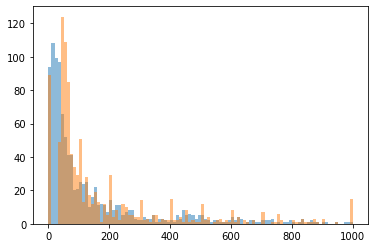

In [77]:
plt.hist(df_val.num_subjects, range=(0,1000),bins=100, alpha=0.5 )
plt.hist(pred_proba, range=(0,1000),bins=100, alpha=0.5 )

## Subjects

In [78]:
acc = accuracy_score(df_val.num_subjects_clean, df_val["y_pred_num_subjects"])
print (f"Subjects accuracy {acc}")

Subjects accuracy 0.41566820276497696


''

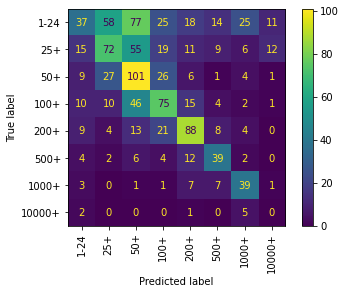

In [79]:
ConfusionMatrixDisplay.from_predictions(df_val.num_subjects_clean, df_val["y_pred_num_subjects"], labels=num_subjects_list)
plt.xticks(rotation=90)
;

In [80]:
num_correct = 0
for idx in range(len(df_val)):
  gt = num_subjects_clean_map[df_val["num_subjects_clean"].iloc[idx]]
  pred = num_subjects_clean_map[df_val["y_pred_num_subjects"].iloc[idx]]
  is_correct = int(np.abs(gt - pred) <= 1)
  num_correct += is_correct
print ("Accuracy including adjacent groups", num_correct/len(df_val))

Accuracy including adjacent groups 0.6903225806451613
